# Modelling & Analysis of Gas Turbine Blade Behavior to Predict Turbine Blade Resonance Amplitudes

# NEURAL NETWORK MODEL

IMPORTING LIBRARIES

In [0]:
import tensorflow as tf
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import os.path as path

from keras.optimizers import Adam
from keras import backend as K

MAKING A SESIION IN KERAS

In [0]:
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1})
sess = tf.compat.v1.Session()
tf.compat.v1.keras.backend.get_session(
    op_input_list=()
)

LOADING DATASETS

In [0]:
train = pd.read_csv("traindata.csv")
train=train.sample(frac=1)
print(np.shape(train))
train.head()

(143, 8)


,N,m,P1,T1,P3,T3,TJC,A
61,94.8,75.3,13.2544,27.0,249.3,725.5,690.7,82.69
41,94.8,75.3,13.1168,27.0,211.6,725.5,690.7,33.08
109,98.6,75.3,13.1168,27.0,249.3,725.5,690.7,62.02
9,94.8,55.7,13.1168,27.0,211.6,725.5,690.7,16.54
42,94.8,75.3,13.1168,27.0,211.6,761.0,637.7,33.08


LOADING VALIDATION DATA

In [0]:
validate = pd.read_csv("validatedata.csv")
#validate = validate.sample(frac=1)
validate=validate.rename(columns={"Amplitude (Max)": "A"})
print(np.shape(validate))
validate.head()

(43, 8)


,N,m,P1,T1,P3,T3,TJC,A
0,95.84,63.78,13.16,19.59,216.63,735.61,667.44,42.9156
1,97.47,56.41,13.13,22.03,236.53,759.09,683.22,45.2331
2,96.18,64.27,13.21,26.66,225.33,759.51,673.38,65.4893
3,95.90,62.89,13.21,25.73,227.34,732.96,673.73,60.4748
4,94.88,56.32,13.15,20.78,236.98,744.53,669.48,20.7956


APPENDING BOTH TRAINING AND VALIDATION DATASET

In [0]:
train.append(validate,ignore_index=True)

,N,m,P1,T1,P3,T3,TJC,A
0,94.80,75.30,13.2544,27.00,249.30,725.50,690.70,82.6900
1,94.80,75.30,13.1168,27.00,211.60,725.50,690.70,33.0800
2,98.60,75.30,13.1168,27.00,249.30,725.50,690.70,62.0200
3,94.80,55.70,13.1168,27.00,211.60,725.50,690.70,16.5400
4,94.80,75.30,13.1168,27.00,211.60,761.00,637.70,33.0800
...,...,...,...,...,...,...,...,...
181,95.44,72.47,13.2200,20.49,237.12,760.38,686.85,82.7935
182,96.35,57.40,13.1300,26.56,224.70,753.34,646.88,42.6216
183,98.24,62.05,13.1700,20.55,224.12,759.24,642.68,58.6157
184,96.73,69.60,13.1600,24.35,224.97,747.12,688.88,83.8713


In [0]:
train['T3']=train['T3']/10
train['TJC']=train['TJC']/10
train['P3']=train['P3']/10

LOADING TEST DATA

In [0]:
test = pd.read_csv("testdata.csv")
test=test.rename(columns={"NL": "N","Analytical value":"A","TJ":"TJC"})
del test['Experimental value']
print(np.shape(test))
test.head()


(24, 8)


,N,m,P1,T1,P3,T3,TJC,A
0,95.0504,69.8002,13.13,25.8,222.5,752.0,685.0,76.0174
1,95.7920,71.5995,13.16,26.1,233.5,742.9,651.4,72.6498
2,96.1042,72.1003,13.12,26.1,235.2,743.5,646.3,68.9307
3,96.4946,72.4002,13.15,24.5,234.3,761.0,686.9,67.4881
4,97.3730,74.1005,13.15,25.2,243.9,747.9,672.0,68.2048


MAKING ALL INPUT VARIABLES IN RANGE OF 0-1, FOR EASY COMPUTATION

In [0]:
test['T3']=validate['T3']/10
test['TJC']=validate['TJC']/10
test['P3']=validate['P3']/10

SPLITTING INTO TRAINING AND TESTING

In [0]:
features = train.columns[:7]
X_train = train[features]/100
y_train = train['A']/100
X_train=np.asarray(X_train)
y_train=np.asarray(y_train)
features = test.columns[:7]
X_test = test[features]/100
y_test = test['A']/100

In [0]:

X_train

array([[0.948   , 0.753   , 0.132544, ..., 0.2493  , 0.7255  , 0.6907  ],
       [0.948   , 0.753   , 0.131168, ..., 0.2116  , 0.7255  , 0.6907  ],
       [0.986   , 0.753   , 0.131168, ..., 0.2493  , 0.7255  , 0.6907  ],
       ...,
       [0.948   , 0.753   , 0.132544, ..., 0.2493  , 0.761   , 0.6907  ],
       [0.948   , 0.557   , 0.131168, ..., 0.2493  , 0.7255  , 0.6907  ],
       [0.986   , 0.557   , 0.131168, ..., 0.2493  , 0.761   , 0.6377  ]])

In [0]:
y_train

array([0.8269, 0.3308, 0.6202, 0.1654, 0.3308, 0.8269, 0.4961, 0.3308,
       0.63  , 0.2953, 0.2605, 0.945 , 0.7875, 1.1813, 0.6202, 0.8682,
       0.2481, 0.15  , 0.3938, 0.5625, 0.6615, 0.4134, 1.2403, 1.1721,
       0.225 , 0.1969, 0.225 , 0.9767, 0.3101, 0.375 , 0.4725, 0.1538,
       0.4341, 0.5906, 0.4961, 1.1813, 0.6   , 0.4341, 0.2067, 1.3023,
       0.9923, 0.7262, 0.1736, 0.6946, 0.1575, 0.9923, 0.315 , 0.4134,
       0.5906, 0.315 , 0.945 , 0.2363, 0.6615, 0.5906, 0.1538, 0.7875,
       0.2363, 0.4725, 0.1654, 0.2067, 0.3256, 1.0419, 0.3938, 0.3308,
       0.4961, 0.315 , 0.9   , 0.63  , 0.5209, 0.3   , 1.0853, 0.5625,
       0.4134, 0.75  , 0.375 , 0.4341, 0.1688, 0.4341, 0.4725, 0.315 ,
       0.6202, 0.6512, 1.1813, 0.4961, 0.5209, 0.225 , 0.945 , 0.63  ,
       0.4134, 0.9923, 0.3938, 0.3938, 0.6512, 0.5906, 0.9767, 0.6512,
       0.1575, 0.1654, 0.3938, 0.4725, 1.2713, 0.3308, 0.2171, 0.1575,
       0.1969, 0.3   , 0.2481, 0.2363, 0.3256, 0.45  , 0.7875, 0.2953,
      

In [0]:
X_test

,N,m,P1,T1,P3,T3,TJC
0,0.950504,0.698002,0.1313,0.258,0.21663,0.73561,0.66744
1,0.957920,0.715995,0.1316,0.261,0.23653,0.75909,0.68322
2,0.961042,0.721003,0.1312,0.261,0.22533,0.75951,0.67338
3,0.964946,0.724002,0.1315,0.245,0.22734,0.73296,0.67373
4,0.973730,0.741005,0.1315,0.252,0.23698,0.74453,0.66948
5,0.961045,0.718004,0.1314,0.270,0.22941,0.75186,0.64378
6,0.964399,0.728000,0.1319,0.244,0.22665,0.76030,0.66631
7,0.965030,0.739995,0.1316,0.266,0.21533,0.73043,0.67533
8,0.963303,0.725001,0.1320,0.238,0.22611,0.74314,0.67765
9,0.968761,0.737996,0.1320,0.232,0.23840,0.75434,0.64282


NEURAL NETWORK WITH DIFFERENT VARYING PARAMETERS

In [0]:
#NO. OF HIDDEN LAYERS
#NO. OF NEURONS IN EACH LAYER
#NO. OF TIMES ITERATION
#BATCH SIZE

In [0]:
#3 hidden layers
#128 32 8 

In [0]:
k=0
best_rmse=100
rmse_array=[None]*100
epoc=[None]*100
for i in range(0,1000,10):
    model = Sequential()
    model.add(Dense(128, input_dim=7, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    model.fit(X_train, y_train, validation_split=0.20, epochs=i, batch_size=10, verbose=0)
    Y_pred= model.predict(X_test)
    Y_pred=Y_pred*100
    mse=mean_squared_error(y_test*100, Y_pred)
    rmse=mse**(1/2)
    if best_rmse>rmse:
      best_mse=rmse
      Y_pred_best=Y_pred
    rmse_array[k]=rmse
    epoc[k]=i
    k=k+1

In [0]:
rmse_array=np.asarray(rmse_array)
print(rmse_array)
epoc=np.asarray(epoc)
best_rmse=min(rmse_array)
print("Best rmse",best_rmse)
for i in range(0,100):
  if best_rmse==rmse_array[i]:
    index=i
print("epoch index",epoc[index])

[29.77466042 23.64798249 18.46598958 18.28483521 20.07498248 14.97702738
  9.21362814  9.40606333 10.36108195 11.93886122 10.10602472  9.30610405
  8.67039533  8.55328088  9.83667924  8.52267754  8.95015536  8.58158613
  8.79814208  8.80112938 22.93039947  8.41484463  8.54114881 22.81285778
 22.93583881  8.57903866  8.49015832  8.54582587  8.51781473  8.29376613
  8.98081142  8.23705337  8.3587951   9.06704599  8.36801341  8.28497056
  8.70067396  8.92218007  8.32264914  8.67378336  9.525405    8.40257882
 22.86298027  8.46047369  8.38752841  8.30582414  8.72101217  9.97750705
 22.96853265  8.90669936  8.66176486  8.61059203  8.45170563  8.35799783
 22.83314725  8.58746696  8.47350615  8.695063    8.65333311  8.52712118
  8.57141128  8.41500145  9.22537531  9.84212135 10.59834454 10.97026813
 10.90055349  9.61337116  8.46860393  8.86586891  8.40091979  8.46857865
  9.51115563 10.44675207  9.87966388 11.03201425  8.98140221 11.59680421
 10.18396179  8.83817349  9.37212763  9.56184542 11

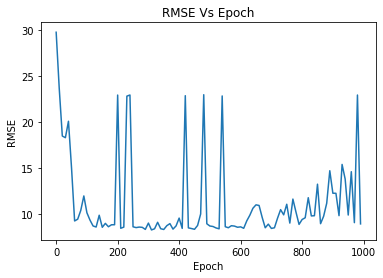

In [0]:
import matplotlib.pyplot as plt
plt.plot(epoc,rmse_array)
plt.title('RMSE Vs Epoch')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.show()

In [0]:
k=0
best_rmse=100
rmse_array=[None]*100
epoc=[None]*100
for i in range(0,1000,10):
    model = Sequential()
    model.add(Dense(128, input_dim=7, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    model.fit(X_train, y_train, validation_split=0.20, epochs=i, batch_size=10, verbose=0)
    Y_pred= model.predict(X_test)
    Y_pred=Y_pred*100
    mse=mean_squared_error(y_test*100, Y_pred)
    rmse=mse**(1/2)
    if best_rmse>rmse:
      best_mse=rmse
      Y_pred_best=Y_pred
    rmse_array[k]=rmse
    epoc[k]=i
    k=k+1

[ 9.65466486 21.2233069  16.21335116 11.63076721 22.20693195 14.38853256
  9.24597223  8.50756561  9.27797762 22.9644035  10.18229407  9.23038352
  8.96637269 23.00885919 11.2471607   9.48430228  8.94934324  8.96085995
  8.7354949   8.45012111  8.76982279  9.39646144  8.7806625  10.17534499
  8.71839054  8.36982084  8.75668298  8.66306979  8.0912385   8.44806826
  8.20916527  8.58914295  8.44561749  9.14444474  8.61110395  8.54102531
  8.4823582   8.44921577  8.59781843  9.18466772  8.59189978  9.20518238
  8.42774823  8.49684873  8.59511876  8.71917266  9.48996544  8.6793531
  8.59492414 22.76567503 11.01480764 23.00134038  8.97109568  8.48458334
  9.03746314 22.93742994  8.62734063  9.00836986  8.84234566  8.5880245
  8.67854087  8.89118006  8.93284525  9.13183045  8.58242957  8.65521141
  8.30500846  8.47582875  9.04231643 10.73058974  8.76610617  8.38960645
 10.42461966 23.02994029 10.52788092  9.62498122  9.12550565 10.32904876
 17.40161424 12.89444131  9.42136441 11.87824425 19.3

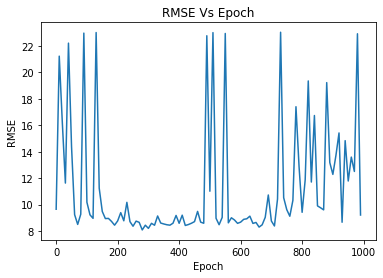

In [0]:
rmse_array=np.asarray(rmse_array)
print(rmse_array)
epoc=np.asarray(epoc)
best_rmse=min(rmse_array)
print("Best rmse",best_rmse)
for i in range(0,100):
  if best_rmse==rmse_array[i]:
    index=i
print("epoch index",epoc[index])
import matplotlib.pyplot as plt
plt.plot(epoc,rmse_array)
plt.title('RMSE Vs Epoch')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.show()

In [0]:
#3 layer
#128 128 128

In [0]:
k=0
best_rmse=100
rmse_array=[None]*100
epoc=[None]*100
for i in range(0,1000,10):
    model = Sequential()
    model.add(Dense(128, input_dim=7, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    model.fit(X_train, y_train, validation_split=0.20, epochs=i, batch_size=10, verbose=0)
    Y_pred= model.predict(X_test)
    Y_pred=Y_pred*100
    mse=mean_squared_error(y_test*100, Y_pred)
    rmse=mse**(1/2)
    if best_rmse>rmse:
      best_mse=rmse
      Y_pred_best=Y_pred
    rmse_array[k]=rmse
    epoc[k]=i
    k=k+1

[17.99666737 19.46640258  9.24611357  9.164244    9.03746995  9.1455252
  9.26440906  8.80542379  9.76040336  8.9026472   8.57674519  9.2114611
  8.36698246  8.89150452  9.34638078  8.76722117  8.46422137  8.75951622
  8.80441725  8.76571769  8.72360528  8.52498116  8.8125458  10.05652771
  8.7896711   8.66666298  8.40300571  9.02929051  9.2492079   8.84475798
  9.86086933  8.76424054  9.01095965 13.19162812  9.36451525 12.18492214
 11.90048226 10.40699249  9.54167877 11.17902387 13.64983133 12.7914185
 10.56621093  9.51275171 15.52871221 10.01946191 12.11054884 15.57015755
 10.41400747 15.1535615  19.69863443 15.7866033  15.03629174 16.02395145
 16.02731826 18.33279401  9.99468219 23.69180347 15.95305628 10.70000953
 17.4657234  15.42252525 20.75313373 20.75887073 15.59043833 18.85795659
 20.67747466 21.68674822 20.75142044 10.26632297 21.2579305  15.76520758
 18.35550504 22.64886703 18.73000634 19.46079459 20.42019179 14.90424333
 20.12755612 24.65021559 20.57821039 22.78590813 22.47

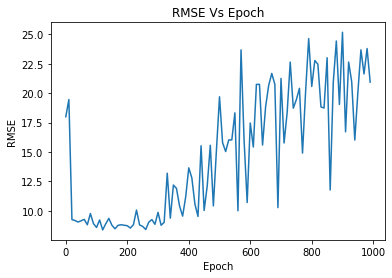

In [0]:
rmse_array=np.asarray(rmse_array)
print(rmse_array)
epoc=np.asarray(epoc)
best_rmse=min(rmse_array)
print("Best rmse",best_rmse)
for i in range(0,100):
  if best_rmse==rmse_array[i]:
    index=i
print("epoch index",epoc[index])
import matplotlib.pyplot as plt
plt.plot(epoc,rmse_array)
plt.title('RMSE Vs Epoch')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.show()

In [0]:
#3 layer
# 128 32 8

In [0]:
k=0
best_rmse=100
rmse_array=[None]*100
epoc=[None]*100
for i in range(0,1000,10):
    model = Sequential()
    model.add(Dense(128, input_dim=7, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    model.fit(X_train, y_train, validation_split=0.20, epochs=i, batch_size=10, verbose=0)
    Y_pred= model.predict(X_test)
    Y_pred=Y_pred*100
    mse=mean_squared_error(y_test*100, Y_pred)
    rmse=mse**(1/2)
    if best_rmse>rmse:
      best_mse=rmse
      Y_pred_best=Y_pred
    rmse_array[k]=rmse
    epoc[k]=i
    k=k+1

[23.6856638  20.29772521 22.23772619 17.47073281 19.62599389 23.11598375
 16.88242247  9.40351118  8.91902336 10.75780646  8.77938018  8.7204416
 12.13056769  8.70841206  9.90639295  9.2207756   8.74823756  8.60523949
  8.90683323  8.70958137  9.00577279  8.30682422  8.47796111 11.44112091
  8.69319033  8.07117834  8.32875224  8.78395371 10.03723105  8.46861125
  8.3214593   8.41699419  8.38434749  8.75828455  8.54033831  8.70266675
  8.37070069  8.63516798  8.46312643  8.29739436  8.31386289  9.21470108
  9.07008638 11.13420403  8.73278107  9.62925325  8.66687851  8.36811657
  8.71836239  9.52624481 10.36717856  8.45906473  9.55716173 10.0663995
  9.06976805  9.15790025  9.97123672  9.67222715  9.33967479  9.14502427
  8.62451537  9.9785209   9.33073439 10.23362109  9.07190442 10.69980671
  9.0542243   9.86914461 12.01570279  9.10810057  8.67151242  8.97408935
  9.71269219  8.48276468 22.90827575 22.82167295  9.43909734 22.95097798
 10.76474302  9.41973846 12.81225848 14.85284383  8.4

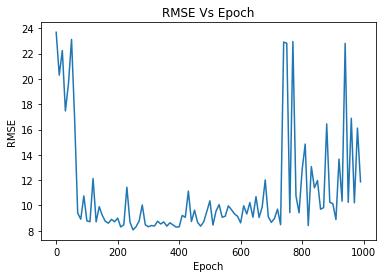

In [0]:
rmse_array=np.asarray(rmse_array)
print(rmse_array)
epoc=np.asarray(epoc)
best_rmse=min(rmse_array)
print("Best rmse",best_rmse)
for i in range(0,100):
  if best_rmse==rmse_array[i]:
    index=i
print("epoch index",epoc[index])
import matplotlib.pyplot as plt
plt.plot(epoc,rmse_array)
plt.title('RMSE Vs Epoch')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.show()

In [0]:
#3 layer
# 128 64 32

[19.50895024 17.04432658 12.233903    9.10035023  9.42758692  9.24134511
  9.68782716  8.86674298  9.63000796  9.49006692  9.5835788   9.25695916
  9.42642556  9.64104232  9.57387468  9.19865122  9.54734528  9.65055249
  9.61761161  9.91396322  9.52552286  9.63839338  9.64332551  9.37888911
  9.66113667  9.52344301  9.42335741  9.27554513 11.37121075  9.20248412
  9.28701026 10.38386527  9.32065712  9.45269639 10.07372112 11.25499039
  9.97394611  9.51998682 12.00471145  9.67323426 10.73002083  9.41218304
 10.09296161 10.72784921 10.10069969  9.67616369 10.53684198  9.49516787
  9.94513155  9.92045834 11.14140444 15.04030112 11.25075827 13.85767589
  9.65670067 11.29699486 11.10441142 13.40529268 12.54048896 12.66660562
 12.43420107 11.07070794 12.62501799 10.55872009 11.67652842 11.87439247
 15.16355838 14.42078469 17.26360584 15.27396891 12.24380753 11.55972131
 15.71127857 18.34748166 12.33773379 17.28184836 12.67040459 13.26005881
 10.01888296 16.19784048 20.7212888  15.57057285 13

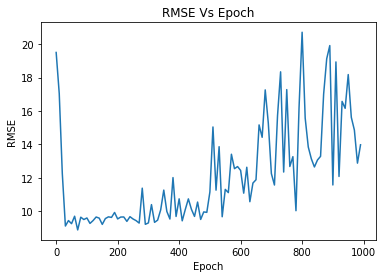

In [0]:
k=0
best_rmse=100
rmse_array=[None]*100
epoc=[None]*100
for i in range(0,1000,10):
    model = Sequential()
    model.add(Dense(128, input_dim=7, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    model.fit(X_train, y_train, validation_split=0.20, epochs=i, batch_size=10, verbose=0)
    Y_pred= model.predict(X_test)
    Y_pred=Y_pred*100
    mse=mean_squared_error(y_test*100, Y_pred)
    rmse=mse**(1/2)
    if best_rmse>rmse:
      best_mse=rmse
      Y_pred_best=Y_pred
    rmse_array[k]=rmse
    epoc[k]=i
    k=k+1
rmse_array=np.asarray(rmse_array)
print(rmse_array)
epoc=np.asarray(epoc)
best_rmse=min(rmse_array)
print("Best rmse",best_rmse)
for i in range(0,100):
  if best_rmse==rmse_array[i]:
    index=i
print("epoch index",epoc[index])
import matplotlib.pyplot as plt
plt.plot(epoc,rmse_array)
plt.title('RMSE Vs Epoch')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.show()

In [0]:
# 2 layer 
# 128 32

[11.74063985 20.25359548 16.30509081 14.91458481 11.29642848 13.0880376
 11.10319637  9.16577066  8.76552006  8.65344046  8.28902062 11.44724067
  8.04077203  8.09518834  8.92984083  8.54198156  8.62226101  8.00657851
  8.32743517  8.18095349  8.13752916  8.77776287  8.3408964   8.06099961
  8.3558409   8.27575689  7.95125503  8.05985103  8.37074313  8.40753786
  7.93880604  8.1522786   8.12592284  7.90335159  8.24393485  8.54331031
  8.10913405  8.36335334  8.90654492  8.160732    8.00452664  8.48200273
  8.18557401  8.63328317  9.37557641  7.95545607  8.09757486  8.98999598
  8.40203849  7.9552843   9.58262178  9.22087422  8.79830179  8.22717601
  8.07795962  8.39579132  8.35886821  7.98924248  8.31894633  9.43988077
  8.61516943  8.00433946  8.11600117  8.47978262  7.92681251  8.3592086
  9.59086798  8.68853613  8.02760259  9.997484    8.72045154  8.79960545
  8.78941409  8.51504005 12.91440258  8.50764072  9.09781704  9.19643699
  8.69602864  8.44767771  8.6613234   9.90280178  8.6

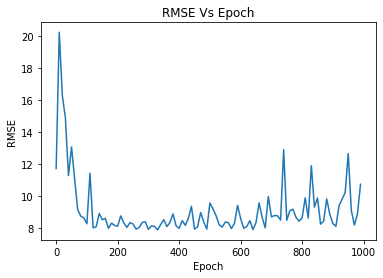

In [0]:
k=0
best_rmse=100
rmse_array=[None]*100
epoc=[None]*100
for i in range(0,1000,10):
    model = Sequential()
    model.add(Dense(128, input_dim=7, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    model.fit(X_train, y_train, validation_split=0.20, epochs=i, batch_size=10, verbose=0)
    Y_pred= model.predict(X_test)
    Y_pred=Y_pred*100
    mse=mean_squared_error(y_test*100, Y_pred)
    rmse=mse**(1/2)
    if best_rmse>rmse:
      best_mse=rmse
      Y_pred_best=Y_pred
    rmse_array[k]=rmse
    epoc[k]=i
    k=k+1
rmse_array=np.asarray(rmse_array)
print(rmse_array)
epoc=np.asarray(epoc)
best_rmse=min(rmse_array)
print("Best rmse",best_rmse)
for i in range(0,100):
  if best_rmse==rmse_array[i]:
    index=i
print("epoch index",epoc[index])
import matplotlib.pyplot as plt
plt.plot(epoc,rmse_array)
plt.title('RMSE Vs Epoch')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.show()

In [0]:
# 2 layer 
# 64 16

[20.8963655  20.0120854  19.34863962 17.04091338 17.2889822  19.6550874
 19.99285384 11.93089792 11.94272516  9.69684503  9.42436036 11.06673392
  8.412797    8.58240812 11.07520864  8.60417261  9.179707    8.6776618
  8.37398694  8.18763971  9.29849332 10.46172917  8.25508022  8.2738078
  8.14228973  9.80956273  8.11520184  8.12040345  8.06272753  7.82080242
  8.2161478   9.47238077  7.82936335  8.81613307  7.94874569  9.45108195
  9.54092068  7.94966549  8.01884388  8.90260522  8.48331617  7.87452155
  8.11520208  8.23370038  8.03446491  7.98421301  8.45081547  9.91528821
  8.1839775   8.74934262  7.95096807  7.98018056  8.01774091  8.06543498
  7.83361521  7.78875626  8.15129151  8.66650689  8.32603564  8.05670714
  9.44983438  8.01333557  7.94736931  7.88813957  8.74933613  9.95662573
  8.00277451  7.90011223  7.98096993  7.9769502   8.09213296  8.30902205
  8.30641503  8.07379094  7.85678982  8.25082804 10.38908473  8.58296253
  8.84464346  7.97969046  8.14528179  9.17982366  8.05

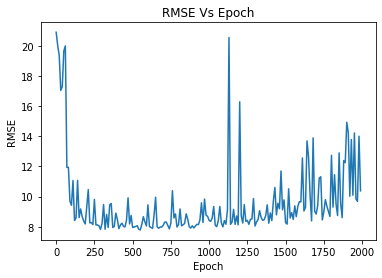

In [0]:
k=0
best_rmse=100
rmse_array=[None]*200
epoc=[None]*200
for i in range(0,2000,10):
    model = Sequential()
    model.add(Dense(64, input_dim=7, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    model.fit(X_train, y_train, validation_split=0.20, epochs=i, batch_size=10, verbose=0)
    Y_pred= model.predict(X_test)
    Y_pred=Y_pred*100
    mse=mean_squared_error(y_test*100, Y_pred)
    rmse=mse**(1/2)
    if best_rmse>rmse:
      best_mse=rmse
      Y_pred_best=Y_pred
    rmse_array[k]=rmse
    epoc[k]=i
    k=k+1
rmse_array=np.asarray(rmse_array)
print(rmse_array)
epoc=np.asarray(epoc)
best_rmse=min(rmse_array)
print("Best rmse",best_rmse)
for i in range(0,200):
  if best_rmse==rmse_array[i]:
    index=i
print("epoch index",epoc[index])
import matplotlib.pyplot as plt
plt.plot(epoc,rmse_array)
plt.title('RMSE Vs Epoch')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.show()

In [0]:
# 2 layer 
# 64 8

[28.29832737 18.7742578  19.27830734 18.33824439 14.92878962 15.34311565
 14.02577787 10.16076176 12.4851883   9.6765897   8.85549378 10.66675229
  8.41380145  8.70377514  8.74556707  9.94738112  7.81291306  9.84804187
  8.45344383  8.99774315  7.95853552  8.02535111  7.95204058  8.38066915
  8.199998    9.68074616  8.1555657   8.30836884  8.1078244   7.96207625
  8.01903678  7.99193029  7.80700252  8.29292266  8.15810517  9.38673214
  8.13631418  8.19807149  8.01166508  7.99703363  8.0289101   8.17794337
  8.7270396   8.57114705  7.97877119  8.06581787  7.92182314  8.85865106
  9.18130709  8.50072722  7.99183047  9.553082    8.26751061  7.90523802
  7.91079428  7.96727488  8.0067141   8.83689948  8.01653623  7.9825818
  8.34404901  9.4983968   8.09709571  8.56283854  7.92189002  7.92192037
  7.90694342  8.01459584  8.26713344  8.08675042  8.91858185  7.90052346
  8.13564795  8.12219053  8.05273918  8.15133867  8.08797124  9.57042108
  8.81909784  9.9899225   8.15533075  8.50718075  8.

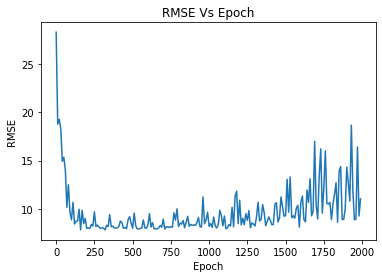

In [0]:
k=0
best_rmse=100
rmse_array=[None]*200
epoc=[None]*200
for i in range(0,2000,10):
    model = Sequential()
    model.add(Dense(64, input_dim=7, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    model.fit(X_train, y_train, validation_split=0.20, epochs=i, batch_size=10, verbose=0)
    Y_pred= model.predict(X_test)
    Y_pred=Y_pred*100
    mse=mean_squared_error(y_test*100, Y_pred)
    rmse=mse**(1/2)
    if best_rmse>rmse:
      best_mse=rmse
      Y_pred_best=Y_pred
    rmse_array[k]=rmse
    epoc[k]=i
    k=k+1
rmse_array=np.asarray(rmse_array)
print(rmse_array)
epoc=np.asarray(epoc)
best_rmse=min(rmse_array)
print("Best rmse",best_rmse)
for i in range(0,200):
  if best_rmse==rmse_array[i]:
    index=i
print("epoch index",epoc[index])
import matplotlib.pyplot as plt
# 2 layer 
# 64 16lt
plt.plot(epoc,rmse_array)
plt.title('RMSE Vs Epoch')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.show()

In [0]:
# 2 layer
# 64 64

[33.13075296 21.21660438 19.05620133 12.71633334 16.39447194 10.48008928
  9.2148091  16.55303865 11.06744644 12.93299256 10.0486206   8.89126843
  8.23199129  8.19109265  8.110437    9.25293389  8.23563921  8.33740125
  8.67888838  8.04589988  8.5968825   7.96213728  8.61407437  7.89791057
  7.95427609  8.07180068  8.10995923  8.09080115  8.11613498  7.9846424
  8.50980242  8.3367323   8.05104923  8.46759078  7.9435465   8.98285815
  8.17071807  8.564355    8.14641964  8.09208913  7.9592177   8.07416376
  8.10213066  7.92174886  8.07749449  8.05567591  7.92859445  8.72524699
  8.21148069  7.90967206  9.45180034  8.10497997  8.10027449  8.35841681
  8.67149044  8.30444601  8.30047546  8.38922458  8.69299196  8.7002957
  8.77111121  8.47996458  8.35096211  8.61332582  8.22375622  8.28868445
 11.2075374   8.3045612   8.54003148  8.07302425  8.1808548   9.19441422
  8.57973614  8.10714963  9.8503062   9.61853192  9.36451257 10.49922505
  7.97188709  9.26264099  8.72556887  9.93214972  8.2

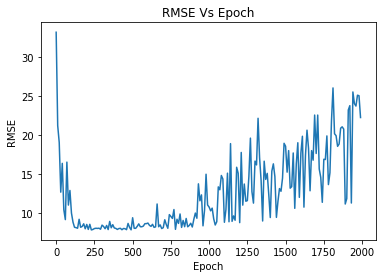

In [0]:
k=0
best_rmse=100
rmse_array=[None]*200
epoc=[None]*200
for i in range(0,2000,10):
    model = Sequential()
    model.add(Dense(64, input_dim=7, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    model.fit(X_train, y_train, validation_split=0.20, epochs=i, batch_size=10, verbose=0)
    Y_pred= model.predict(X_test)
    Y_pred=Y_pred*100
    mse=mean_squared_error(y_test*100, Y_pred)
    rmse=mse**(1/2)
    if best_rmse>rmse:
      best_mse=rmse
      Y_pred_best=Y_pred
    rmse_array[k]=rmse
    epoc[k]=i
    k=k+1
rmse_array=np.asarray(rmse_array)
print(rmse_array)
epoc=np.asarray(epoc)
best_rmse=min(rmse_array)
print("Best rmse",best_rmse)
for i in range(0,200):
  if best_rmse==rmse_array[i]:
    index=i
print("epoch index",epoc[index])
import matplotlib.pyplot as plt
# 2 layer 
# 64 16lt
plt.plot(epoc,rmse_array)
plt.title('RMSE Vs Epoch')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.show()

In [0]:
# 2 layer
# 16 8

[24.82228605 19.75400375 19.03037697 18.87356455 20.06642715 17.37055172
 18.03090606 18.38336492 17.6462288  16.57666584 19.83448702 20.59048419
 20.69736993 17.89013207 11.19825706 11.07990731  9.13809095 10.26988544
  8.60187348  9.32634377  8.67936561 10.65185652  9.19237306  8.44585193
  8.71868644  9.58549742 20.51295809 10.44378989  8.90484983  8.25071872
  8.27366743  9.15603519  8.16693873 20.47319933  8.28060149  8.4591073
  7.97063466  8.70086187  9.20981693  8.58229165  8.61005002  8.72204528
  9.42164762  8.07813789  7.94314412  7.85851836  7.99154824  9.20147482
  8.20785044  8.79351348  8.04489551  9.02743095  8.11329822  8.02695694
  8.38145274  9.8941056   7.92080221  8.340237    8.22456146  9.45906031
  8.03152799  8.17120444  8.43615202  7.76579384  7.92357414  8.03038269
  8.04507242  8.29066688  8.58742003  8.69001386  9.8745168   7.94787612
  8.39379615  8.06631426  8.49716939  9.76926328  8.11745808  8.59790414
  8.51113803  8.20200943  7.9098232   8.3011557   8.

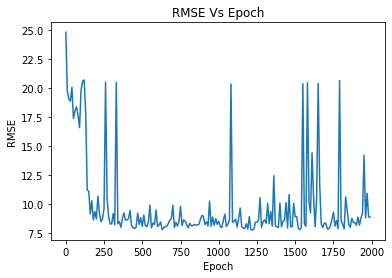

In [0]:
k=0
best_rmse=100
rmse_array=[None]*200
epoc=[None]*200
for i in range(0,2000,10):
    model = Sequential()
    model.add(Dense(16, input_dim=7, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    model.fit(X_train, y_train, validation_split=0.20, epochs=i, batch_size=10, verbose=0)
    Y_pred= model.predict(X_test)
    Y_pred=Y_pred*100
    mse=mean_squared_error(y_test*100, Y_pred)
    rmse=mse**(1/2)
    if best_rmse>rmse:
      best_mse=rmse
      Y_pred_best=Y_pred
    rmse_array[k]=rmse
    epoc[k]=i
    k=k+1
rmse_array=np.asarray(rmse_array)
print(rmse_array)
epoc=np.asarray(epoc)
best_rmse=min(rmse_array)
print("Best rmse",best_rmse)
for i in range(0,200):
  if best_rmse==rmse_array[i]:
    index=i
print("epoch index",epoc[index])
import matplotlib.pyplot as plt
plt.plot(epoc,rmse_array)
plt.title('RMSE Vs Epoch')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.show()

In [0]:
# 2 layer
8 4

[27.8680474  22.96974734 21.39511408 19.40329387 19.83850877 19.59606315
 18.58761265 19.73371022 20.73885264 19.5909214  20.15054074 17.87273728
 18.9834424  18.25025417 18.11396677 17.27448718 17.2050672  20.54521498
 15.58160972  9.1754232   9.12065602 11.54558353 16.56762378 18.45199438
  8.96249392 19.88694639 12.61445631  9.79808676 20.37759146 12.73002686
 10.81327617 13.47445128 11.6124782  10.91389901  9.56338257 16.87724825
  8.14101329 20.53065493 20.47814782  9.30810928  9.21166395 10.45867396
  8.975254    9.92495456  9.05587639  8.55489447 18.77766635  8.42633064
 20.52581679  9.59156368  8.54118092  8.31504308 12.03068062  8.3192116
  7.93748938  9.15777011 20.41265928  8.70672121  9.76491477  8.49919917
  8.74552251  8.2352986   8.33423251  8.15092698  8.04241088  8.41676282
  8.24267771 20.4661594   8.85495789  9.62192776  9.22109749  9.51415111
 16.79404923  8.00161881  9.66496895  8.56449917  8.06778527  7.82516276
  7.99542147  8.38227641  8.1654042   8.10371672 20.

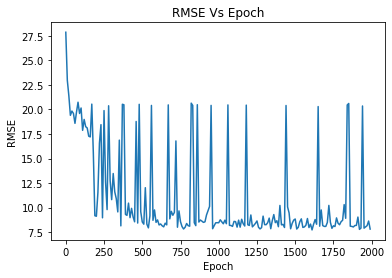

In [0]:
k=0
best_rmse=100
rmse_array=[None]*200
epoc=[None]*200
for i in range(0,2000,10):
    model = Sequential()
    model.add(Dense(8, input_dim=7, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # Fit the model
    model.fit(X_train, y_train, validation_split=0.20, epochs=i, batch_size=10, verbose=0)
    Y_pred= model.predict(X_test)
    Y_pred=Y_pred*100
    mse=mean_squared_error(y_test*100, Y_pred)
    rmse=mse**(1/2)
    if best_rmse>rmse:
      best_mse=rmse
      Y_pred_best=Y_pred
    rmse_array[k]=rmse
    epoc[k]=i
    k=k+1
rmse_array=np.asarray(rmse_array)
print(rmse_array)
epoc=np.asarray(epoc)
best_rmse=min(rmse_array)
print("Best rmse",best_rmse)
for i in range(0,200):
  if best_rmse==rmse_array[i]:
    index=i
print("epoch index",epoc[index])
import matplotlib.pyplot as plt
plt.plot(epoc,rmse_array)
plt.title('RMSE Vs Epoch')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.show()

# THUS, MINIMUM DEVIATION OBTAINED IS 7.7285